In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00


In [58]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense, Input, Dropout, Embedding,regularization, Bidirectional, LSTM, GRU, Flatten, LayerNormalization
from keras.preprocessing.text import Tokenizer, one_hot
from keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

from nltk.tokenize import TweetTokenizer
from transformers import AutoTokenizer, AutoModel

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, average_precision_score, confusion_matrix, classification_report

import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import re
np.random.seed(123)

In [47]:
#!git clone https://github.com/KakhramonUktamov/datasets
def load_dataset():
  data=pd.read_csv("datasets/Offensive-language-tweet-dataset.csv")
  return data

In [83]:
#reference from
#https://www.kaggle.com/amackcrane/python-version-of-glove-twitter-preprocess-script
#https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
  text = text.group()
  hashtag_body = text[1:]
  if hashtag_body.isupper():
      result = " {} ".format(hashtag_body.lower())
  else:
      result = " ".join([""] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
  return result

def allcaps(text):
    text = text.group()
    return text.lower() + "  "


def clean_data(text):
  eyes = r"[8:=;]"
  nose = r"['`\-]?"

  def re_sub(pattern, repl):
    return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "") #convert urls to
    text = re_sub(r"@\w+", "") #convert mentions to
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}p+".format(eyes, nose), "")
    text = re_sub(r"{}{}+{}{}".format(eyes, nose, nose, eyes), "")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "")
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "")#convert digit to
    text = re_sub(r"#\w+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 ")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 ")
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"", r"( \1 )")
    text = re_sub(r"  ", r" ")
    text = re_sub(r" ([A-Z]){2,} ", allcaps)

  return text.lower()
###########################################################################################################

def preprocessing_tweet(tweet_df):
  temp_list= []
  for t in tweet_df['tweet']:
    temp_list.append(clean_data(t))
  tweet_df['clean_tweet'] = temp_list
  return tweet_df

In [94]:
def split_tweet(cleantweet):
  trainX, tempX=train_test_split(cleantweet, test_size=0.4, random_state=42)
  testX, valX=train_test_split(tempX, test_size=0.5, random_state=42)
  return trainX, testX, valX

def extract_tweet(data):
  tweet, target=data['clean_tweet'], data['class']
  return tweet, target

def keras_tokenizer(train_tw, test_tw, val_tw, max_number_words=100):
  tk=Tokenizer()
  tk.fit_on_texts(train_tw)
  word_index=tk.word_index
  vocab_size=len(word_index)+1

  train_vector=tk.texts_to_sequences(train_tw)
  test_vector=tk.texts_to_sequences(test_tw)
  val_vector=tk.texts_to_sequences(val_tw)

  train_padded=pad_sequences(train_vector, maxlen=max_number_words, padding='post')
  test_padded=pad_sequences(test_vector, maxlen=max_number_words, padding='post')
  val_padded=pad_sequences(val_vector, maxlen=max_number_words, padding='post')

  return train_padded, test_padded, val_padded, word_index, vocab_size, tk


#one hot encode y
def prepare_target(raw_y):
  class_weight = compute_class_weight('balanced', classes=[0,1,2], y=raw_y)
  class_weight_dict = dict((c,w) for c, w in enumerate(class_weight))
  target = to_categorical(raw_y)
  return np.array(target), class_weight_dict

In [95]:
def Bidirectional_lstm(param={}):
  max_seq_len=param['max length']


  vocab_size=param['vocab size']

  embedding_trainable=True
  e=Embedding(vocab_size, 100, embeddings_initializer='uniform',input_length=max_seq_len,
              trainable=embedding_trainable)

  embedding_matrics=param['embedding matrics']
  if embedding_matrics is not None:
    embedding_trainable=False
    e=Embedding(vocab_size, 100, embeddings_regularizer='uniform', input_length=max_seq_len,
                trainable=embedding_trainable, weights=[embedding_matrics])

  inputs=Input(shape=(max_seq_len,), dtype='int64', name='inputs')
  x=e(inputs)
  x=Bidirectional(LSTM(100, return_sequences=True, dropout=param['dropout']))(x)
  x=Bidirectional(LSTM(100, return_sequences=True, dropout=param['dropout']))(x)
  x=Flatten()(x)
  x=LayerNormalization()(x)
  x=Dense(param['first layer'], activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
  x=Dropout(param['dropout'])(x)
  x=LayerNormalization()(x)
  x=Dense(param['second layer'])(x)
  x=Dropout(param['dropout'])(x)
  outputs=Dense(3, activation='softmax')(x)
  model=keras.Model(inputs, outputs)
  model.summary()

  return model



In [101]:
def train_model(model, tweet_train, y_train, tweet_val, y_val, batch_size, num_epochs, class_weight):

  es = keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
  history = model.fit(
            tweet_train, y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_data=(tweet_val, y_val),
            class_weight = class_weight,
            callbacks=[es])
  return model, history

def compile_model(model):
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
                metrics=['accuracy',
                         keras.metrics.AUC(curve="ROC", multi_label=True),
                         keras.metrics.AUC(curve="PR", multi_label=True),
                         keras.metrics.Precision(),
                         keras.metrics.Recall()])
  return model


def evaluate_model(probs, y_test):
    # print(probs)
    # print(y_test)

    probs = probs.argmax(1)
    eval_dict = {
        "Hate": {
            "pr_auc": average_precision_score(y_test[:, 0], probs==0), "pr_auc_random_guess": sum(y_test[:, 0])/(1.0*y_test.shape[0]),
            "roc_auc": roc_auc_score(y_test[:, 0], probs==0), "roc_auc_random_guess": 0.5,
            "precision": precision_score(y_test[:, 0], probs==0),
            "recall": recall_score(y_test[:, 0], probs==0)
        },
        "Offensive": {
            "pr_auc": average_precision_score(y_test[:, 1], probs==1), "pr_auc_random_guess": sum(y_test[:, 1])/(1.0*y_test.shape[0]),
            "roc_auc": roc_auc_score(y_test[:, 1], probs==1), "roc_auc_random_guess": 0.5,
            "precision": precision_score(y_test[:, 1], probs==1),
            "recall": recall_score(y_test[:, 1], probs==1)
        },
        "Neither": {
            "pr_auc": average_precision_score(y_test[:, 2], probs==2), "pr_auc_random_guess": sum(y_test[:, 2])/(1.0*y_test.shape[0]),
            "roc_auc": roc_auc_score(y_test[:, 2], probs==2), "roc_auc_random_guess": 0.5,
            "precision": precision_score(y_test[:, 2], probs==2),
            "recall": recall_score(y_test[:, 2], probs==2)
        }
    }
    return eval_dict


#Create Batch Prediction for out of GPU memory solution
def model_batch_predict(model, model_inputs_and_masks_test, batch_size=100):

    probs = np.empty((0,3))
    # last_batch = model_inputs_and_masks_test.shape[1] % batch_size
    i = 0
    if type(model_inputs_and_masks_test) is dict:
      iteration = int(model_inputs_and_masks_test['inputs'].shape[0] / batch_size)
      for i in range(iteration):
        test = {'inputs':model_inputs_and_masks_test['inputs'][i*batch_size:(i+1)*batch_size],
                'masks': model_inputs_and_masks_test['masks'][i*batch_size:(i+1)*batch_size]}
        probs= np.concatenate((probs, np.array(model(test, training=False))))
      last_batch_test =  {'inputs':model_inputs_and_masks_test['inputs'][(i+1)*batch_size:],
                          'masks': model_inputs_and_masks_test['masks'][(i+1)*batch_size:]}
      probs= np.concatenate((probs, np.array(model(last_batch_test, training=False))))

    else:
      probs = model(model_inputs_and_masks_test, training=False)

    return np.array(probs)

In [104]:
def plot_confusion_matrix(predict, y_true):
  y_predict = predict.argmax(1)
  class_hate = pd.DataFrame(confusion_matrix(y_test[:,0], y_predict==0))
  class_offensive = pd.DataFrame(confusion_matrix(y_test[:,1], y_predict==1))
  class_neither = pd.DataFrame(confusion_matrix(y_test[:,2], y_predict==2))

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
  sns.set(font_scale=1.5)#for label size
  sns.heatmap(class_hate, cmap="cool", annot=True, fmt='g', ax=ax1, cbar=False)
  sns.heatmap(class_offensive, cmap="Greens", annot=True, fmt='g', ax=ax2, cbar=False)
  sns.heatmap(class_neither, cmap="YlGnBu", annot=True, fmt='g', ax=ax3, cbar=False)

  ax1.set_ylabel('True')
  ax2.set_ylabel('True')
  ax3.set_ylabel('True')
  ax1.set_xlabel('Predicted')
  ax2.set_xlabel('Predicted')
  ax3.set_xlabel('Predicted')
  ax1.set_title('Hate')
  ax2.set_title('Offensive')
  ax3.set_title('Neither')

  plt.tight_layout()
  plt.show


In [61]:

def print_classification_report(predict, y_true):
  y_predict = predict.argmax(1)
  class_hate = classification_report(y_test[:,0], y_predict==0)
  class_offensive = classification_report(y_test[:,1], y_predict==1)
  class_neither = classification_report(y_test[:,2], y_predict==2)

  print("Hate Speech".center(60), "\n", class_hate, "\n\n",
        "Offensive Speech".center(60), '\n', class_offensive, '\n',
        "Neither".center(60), '\n', class_neither)


In [97]:
#EXECUTION

raw_df = load_dataset()
clean_df = raw_df
clean_df = preprocessing_tweet(clean_df)

train_df, val_df, test_df = split_tweet(clean_df)

X_train, y_train = extract_tweet(train_df)
X_val, y_val = extract_tweet(val_df)
X_test, y_test = extract_tweet(test_df)


y_raw, class_weight_raw = prepare_target(clean_df['class'])
y_train, class_weight_train = prepare_target(y_train)
y_val, class_weight_val = prepare_target(y_val)
y_test, class_weight_test = prepare_target(y_test)


In [98]:
x_train_lstm, x_val_lstm,x_test_lstm,word_index, vocab_size, tokenizer= keras_tokenizer(X_train,X_test, X_val)

In [99]:
#BiDirectional LSTM Model

Bidirectional_lstm_model = Bidirectional_lstm(param={'max length': 100,
                                  'vocab size': vocab_size,
                                  'embedding matrics': None,
                                  'dropout':0.20,
                                  'first layer' : 128,
                                  'second layer' : 64,
                                  })
Bidirectional_lstm_model = compile_model(Bidirectional_lstm_model)

%time Bi_dir_lstm_model, history_lstm = train_model(Bidirectional_lstm_model, x_train_lstm, y_train, x_val_lstm, y_val, batch_size=64,num_epochs=10, class_weight=class_weight_train)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 100, 100)          2607000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 100, 200)         160800    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 100, 200)         240800    
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 20000)             0         
                                                                 
 layer_normalization_8 (Laye  (None, 20000)            4000

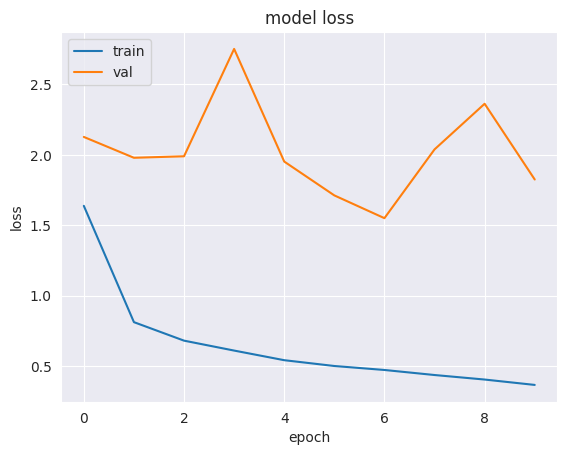

In [100]:
#Model Loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [102]:
#Saving the model
Bidirectional_lstm_model.save("BiDirectional_LSTM_model.h5")

BiDirLstm_prediction=model_batch_predict(Bidirectional_lstm_model, x_test_lstm)


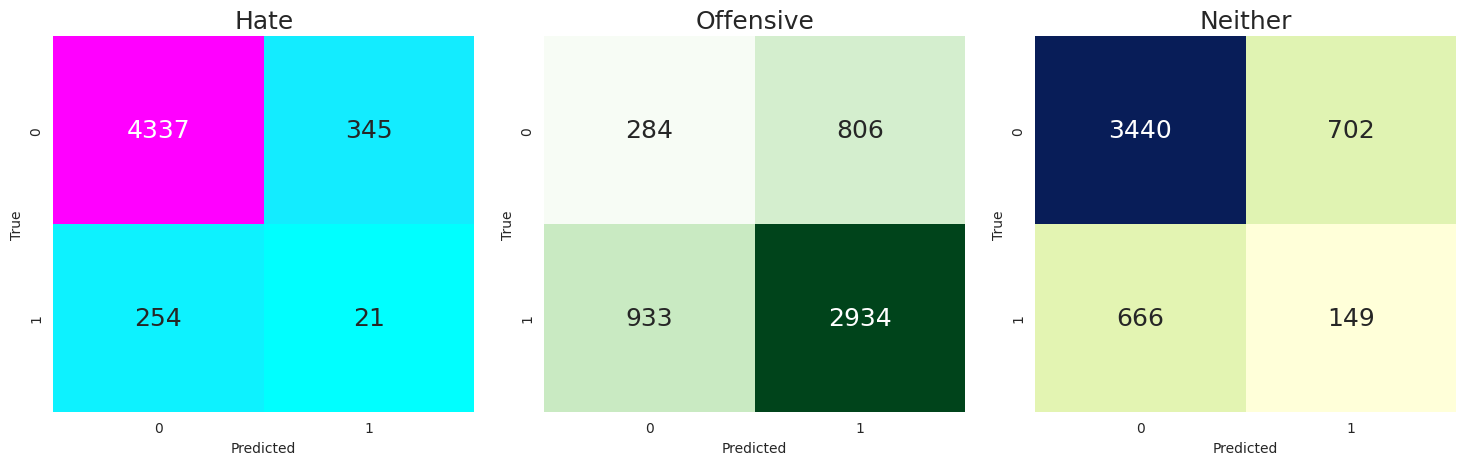

In [105]:
plot_confusion_matrix(BiDirLstm_prediction, y_test)